# **Challenge Nexialog**

#### Objectif du projet
<p style="text-align: justify;">
Des tests sont réalisés dans toutes les boxs, permettant d'identifier implicitement les interruptions de réseau.
L'objectif est de mettre en place une approche non supervisé pour détecter des futurs problèmes sur une partie du réseau → Détection « d’anneaux ». Il faut détecter les noeuds du réseau qui sont défaillants en essayant d’anticiper le plus possible à l’avance.
</p>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import seaborn as sns

### Importation

In [8]:
df = pd.read_parquet(r'data\250327_tests_fixe_dns_sah_202412_202501.parquet', engine="pyarrow")

## EDA

#### Exploration

In [7]:
print(df.shape)
df.head()

In [8]:
df.tail(2)

C'est une période de tests de 2 mois avec une fréquence par heure

In [9]:
df.dtypes

In [10]:
def afficher_pourcentage_valeurs_manquantes(df):
    pourcentage_manquantes = round(df.isna().mean() * 100, 2)
    pourcentage_manquantes = pourcentage_manquantes.sort_values(ascending=False)
    print("Pourcentage de valeurs manquantes par variable (en %) :\n")
    print(pourcentage_manquantes)

afficher_pourcentage_valeurs_manquantes(df)

Preprocessing de la date

In [11]:
df['date_hour'] = pd.to_datetime(df['date_hour'])
df['date_hour'].tail()

Modèles d'OLT :

In [12]:
df.olt_model.unique()

**Observons les liens entre les différentes étapes du réseau**

In [13]:
df['OLT_PEAG_boucle'] = df['olt_name'] + df['peag_nro']  + df['boucle'] 

In [14]:
print('Nombre total de combinaisons OLT x PEAG x boucle :',df['OLT_PEAG_boucle'].nunique())
print('Nombre de noms de OLT :', df.olt_name.nunique())
print('Nombre de noms de PEAG :', df.peag_nro.nunique())
print('Nombre de noms de boucle :', df.boucle.nunique())
print('Nombre de noms de PEBIB :', df.pebib.nunique())
print('Nombre de noms de DSP :', df.dsp.nunique())


# print('Nombre de départements :', df.code_departement.nunique())

Nombre d'associations de chaque noeud à l'autre

In [15]:
print('Nombre d\'OLT par PEAG :', round(df.groupby('peag_nro')['olt_name'].nunique().mean(), 2))
print('Nombre de PEAG par boucle :', round(df.groupby('boucle')['peag_nro'].nunique().mean(), 2))
print('Nombre de boucle par PEBIB :', round(df.groupby('pebib')['boucle'].nunique().mean(), 2))
print('Nombre de PEBIB par DSP :', round(df.groupby('dsp')['pebib'].nunique().mean(), 2))

Nombre de noeuds testés par heure

In [16]:
exemple_date_list = [
    '2024-12-30 23:00:00',
    '2025-01-14 01:00:00',
    '2025-01-01 10:00:00',
    '2024-12-17 12:00:00',
    '2024-12-12 07:00:00'
]

for date in exemple_date_list:
    df_exemple = df[df['date_hour'] == date].copy()
    print('Nombre de boucles testées le', date, ':')
    print('Nombre de lignes pour cette date :', len(df_exemple))
    print('Nombre total de boucles x PEAG x OLT :',df_exemple['OLT_PEAG_boucle'].nunique())
    print('Nombre de noms de OLT :', df_exemple.olt_name.nunique())
    print('Nombre de noms de PEAG :', df_exemple.peag_nro.nunique())
    print('Nombre de noms de PEBIB :', df_exemple.pebib.nunique())
    print('Nombre de noms de DSP :', df_exemple.dsp.nunique())
    print('-'*5)
    print('Nombre de départements :', df_exemple.code_departement.nunique())
    print('-'*50)
    

#### Data Analyse

**Obervons un seul OLT particulier**

In [17]:
olt_choisi = '01_olt_5'

In [18]:
df_one_olt = df[df['olt_name'] == olt_choisi]
print(df_one_olt.shape)
print('Nombre d\'heures :', df_one_olt['date_hour'].nunique())
df_one_olt.head()

24 h * 31 jours * 2 mois = 1488. Ici, on a 1632 lignes, observons pourquoi :

In [19]:
df_one_olt_duplicate = df_one_olt[df_one_olt['date_hour'].duplicated(keep=False)]
print('Nombre de lignes qui ont été dupliquées :', len(df_one_olt_duplicate))

Observons les lignes qui sont dupliquées :

In [20]:
df_one_olt_duplicate.sort_values(by='date_hour', inplace=True)
df_one_olt_duplicate.head()

Cela semble être des erreurs, le même test affiché plusieurs fois. Il faut donc les supprimer.

In [21]:
df_one_olt = df_one_olt.drop_duplicates(subset='date_hour', keep='first')
df_one_olt.shape

**Visualisations**

Ajout de colonnes

In [22]:
pio.renderers.default = 'notebook'
col_palette=['#5533FF','#19A368','#521265','#751818',"#FF5733",'#5533FF','#19A368','#5533FF','#19A368', '#521265']
col_to_plot = ['nb_test_dns', 'avg_dns_time', 'std_dns_time', 'nb_test_scoring', 'avg_latence_scoring',
       'std_latence_scoring', 'avg_score_scoring', 'std_score_scoring', 'nb_client_total']

Lineplots

In [23]:
# visualisation d'un OLT
for i, feature in enumerate(col_to_plot):
    plt.figure(figsize=(10, 5))
    plt.plot(df_one_olt['date_hour'], df_one_olt[feature], label=feature, color=col_palette[i])
    
    plt.title(f"{feature} - {olt_choisi}")
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

    plt.xticks(rotation=45)
    
    plt.show()

On peut supposer que les pics dans les données de variables de test sont associées à des problèmes sur le réseau. Ce sont certainement des anomalies.

Histogrammes (Distribution)

In [24]:
# Visualisation avec des histogrammes
for i, feature in enumerate(col_to_plot):
    plt.figure(figsize=(10, 5))

    plt.hist(df_one_olt[feature], bins=100, color=col_palette[i], alpha=0.7, label=feature)
    

    plt.title(f"Distribution de {feature} - {olt_choisi}")
    plt.xlabel(feature)
    plt.ylabel('Fréquence')
    
    plt.legend()
    plt.grid(True)

    plt.show()

Les valeurs des queues de distribution sont certainement des anomalies

# Sélection des données

In [9]:
def visualize_distribution_single(df, label):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['count'], bins=30)
    plt.title(f'Distribution of Counts - {label}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.show()

In [10]:
# Check how many rows in df thats have 0 in std columns
print('Number of rows with 0 in std columns:')
print(df[(df['std_dns_time'] == 0) | (df['std_latence_scoring'] == 0) | (df['std_score_scoring'] == 0)].shape[0])


Number of rows with 0 in std columns:
1209210


In [13]:
def select_the_data(df, seuil) :

    """  
    Cette fonction récupère un DataFrame et un seuil en paramètre et retourne un nouveau DataFrame
    contenant uniquement les combinaisons PEAG x OLT x PEBIB x boucle x code_departement sans duppliqués
    """
    
    initial_shape = df.shape
    print(f'Shape du DF orginal : {initial_shape}')

    cols_to_fix = ['avg_dns_time', 'std_dns_time', 'std_latence_scoring', 'std_score_scoring', 'avg_latence_scoring', 'avg_score_scoring'] 
    std_cols = ['std_dns_time', 'std_latence_scoring', 'std_score_scoring']

    df[cols_to_fix] = df[cols_to_fix].round(3) # On arrondi car parfois 2 lignes parfaitement identiques vont différer seulement par 
    # quelques décimales, ce qui n'est pas détecté par la fonction drop_duplicates.
    df['pebib'] = df['pebib'].fillna('PEBIB non defini')
    
    df = df.drop_duplicates()
    print('La suppression des lignes parfaitement identiques a permis de supprimer', initial_shape[0] - df.shape[0], 'lignes')
    next_shape = df.shape

    df = df.drop_duplicates(subset=['date_hour','peag_nro', 'olt_name', 'pebib', 'boucle', 'code_departement', 'olt_model', 'dsp', 'pop_dns'], keep='first')
    print('La suppression des lignes parfaitement identiques sauf en les colonnes de tests, mais pour lesquelles ces-dernières sont très proche :', next_shape[0] - df.shape[0], 'lignes')
    next_shape = df.shape


    df['PEAG_OLT_PEBIB'] = df['peag_nro'].astype(str) + df['olt_name'].astype(str) + df['pebib'].astype(str) + df['boucle'].astype(str) + df['code_departement'].astype(str)
    df_peag = df['PEAG_OLT_PEBIB'].value_counts().reset_index()
    df_peag.columns = ['PEAG_OLT_PEBIB', 'count']
    valid_values = df_peag[df_peag['count'] >= seuil]['PEAG_OLT_PEBIB'] # On sélectionne uniquement les combinaisons possédant plus de 100 valeurs
    df = df[df['PEAG_OLT_PEBIB'].isin(valid_values)] # On garde uniquement les lignes correspondant à ces combinaisons dans notre DF

    print(f"La suppression des combinaisons disposant de moins de 100 observations a permis de supprimer {next_shape[0] - df.shape[0]} lignes")
    next_shape = df.shape

    for col in std_cols:
        df = df[df[col] != 0] # On supprime les lignes où la valeur de l'écart-type est égale à 0

    print(f"La suppression des lignes où l'écart-type est égal à 0 a permis de supprimer {next_shape[0] - df.shape[0]} lignes")
    df = df.drop(columns=['code_departement', 'olt_model', 'olt_name', 'peag_nro', 'boucle', 'dsp', 'pebib', 'pop_dns', 'nb_client_total'])
    print(f"Finalement, nous avons {df.shape[0]} lignes restantes")
    return df

new_df = select_the_data(df, 100)
new_df_grouped = new_df.groupby('PEAG_OLT_PEBIB').size().reset_index(name='count').sort_values(by='count', ascending=False)
new_df.to_csv("new_df.csv", index=False)


Shape du DF orginal : (9096908, 18)
La suppression des lignes parfaitement identiques a permis de supprimer 0 lignes
La suppression des lignes parfaitement identiques sauf en les colonnes de tests, mais pour lesquelles ces-dernières sont très proche : 0 lignes
La suppression des combinaisons disposant de moins de 100 observations a permis de supprimer 18509 lignes
La suppression des lignes où l'écart-type est égal à 0 a permis de supprimer 1207068 lignes
Finalement, nous avons 7871331 lignes restantes


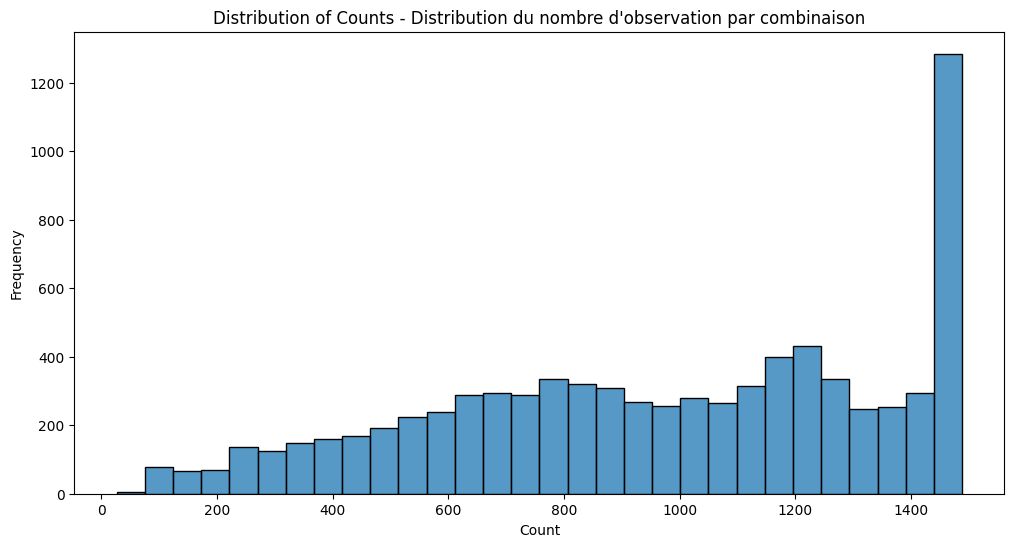

In [12]:
visualize_distribution_single(new_df_grouped, "Distribution du nombre d'observation par combinaison")

In [35]:
new_df